# Stock Price Prediction Using RNNs

<img src="stock_prices.png" style="display:block; margin-left:auto; margin-right:auto;"/>

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [221]:
# Import libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import tensorflow as tf
from keras.layers import LSTM, SimpleRNN, GRU
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [2]:
# Set random seed for reproducibility
np.random.seed(42)  # For NumPy
random.seed(42)     # For Python's built-in random module
tf.random.set_seed(42)  # For TensorFlow (Keras)

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [368]:
# Define a function to load data and aggregate them

def load_and_aggregate(stock_files_list, date_column):
    """
    Load multiple CSV files, concatenate them.

    Parameters:
    - file_list: list of file paths (strings)
    - date_column: the column name to parse as datetime and set as index
    

    Returns:
    - A DataFrame with quarterly mean of the target column
    """
    df_list = []
    base_path = "RNN_Stocks_Data"
    for stock_file in stock_files_list:
        stock_file_path = base_path + "/" + stock_file
        df = pd.read_csv(stock_file_path, parse_dates=[date_column])
        df.set_index(date_column, inplace=True)
        df_list.append(df)

    # Concatenate all dataframes
    df_stocks = pd.concat(df_list)

    return df_stocks


In [370]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

stock_files_list = [ 'GOOGL_stocks_data.csv', 'MSFT_stocks_data.csv', 'AMZN_stocks_data.csv', 'IBM_stocks_data.csv' ]

df_stocks = load_and_aggregate(stock_files_list, 'Date')

In [372]:
# View specifics of the data
df_stocks.head()

Open    High     Low   Close    Volume   Name
Date                                                       
2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL
2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL
2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL
2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL

In [374]:
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12077 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    12076 non-null  float64
 1   High    12077 non-null  float64
 2   Low     12076 non-null  float64
 3   Close   12077 non-null  float64
 4   Volume  12077 non-null  int64  
 5   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 660.5+ KB


In [376]:
df_stocks.describe()

Open          High           Low         Close        Volume
count  12076.000000  12077.000000  12076.000000  12077.000000  1.207700e+04
mean     227.387118    229.422254    225.203189    227.380960  1.671763e+07
std      236.938260    238.568485    234.981015    236.851101  2.570572e+07
min       15.200000     15.620000     14.870000     15.150000  2.542560e+05
25%       54.930000     55.660000     54.425000     55.210000  3.124704e+06
50%      158.795000    160.410000    157.355000    158.880000  5.445269e+06
75%      281.405000    284.500000    278.610000    281.510000  1.802087e+07
max     1204.880000   1213.410000   1191.150000   1195.830000  5.910786e+08

In [378]:
df_stocks['Name'].value_counts()

Name
IBM      3020
GOOGL    3019
MSFT     3019
AMZN     3019
Name: count, dtype: int64

In [380]:
min_date = df_stocks.index.min()
max_date = df_stocks.index.max()

print(f"Date Range: {min_date.date()} to {max_date.date()}")


Date Range: 2006-01-03 to 2017-12-29


In [382]:
print(f"Opening Range: {df_stocks.Open.min()} to {df_stocks.Open.max()}")

Opening Range: 15.2 to 1204.88


In [384]:
print(f"Closing Range: {df_stocks.Close.min()} to {df_stocks.Close.max()}")

Closing Range: 15.15 to 1195.83


In [386]:
print(f"Low Range: {df_stocks.Low.min()} to {df_stocks.High.max()}")

Low Range: 14.87 to 1213.41


In [388]:
print(f"High Range: {df_stocks.Low.min()} to {df_stocks.High.max()}")

High Range: 14.87 to 1213.41


#### Let's also analyse individual stock datasets 

In [391]:
google = pd.read_csv('RNN_Stocks_Data/GOOGL_stocks_data.csv', index_col='Date', parse_dates=['Date'])
google.head()

Open    High     Low   Close    Volume   Name
Date                                                       
2006-01-03  211.47  218.05  209.32  217.83  13137450  GOOGL
2006-01-04  222.17  224.70  220.09  222.84  15292353  GOOGL
2006-01-05  223.22  226.00  220.97  225.85  10815661  GOOGL
2006-01-06  228.66  235.49  226.85  233.06  17759521  GOOGL
2006-01-09  233.44  236.94  230.70  233.68  12795837  GOOGL

In [393]:
microsoft = pd.read_csv('RNN_Stocks_Data/MSFT_stocks_data.csv', index_col='Date', parse_dates=['Date'])
microsoft.head()

Open   High    Low  Close     Volume  Name
Date                                                   
2006-01-03  26.25  27.00  26.10  26.84   79974418  MSFT
2006-01-04  26.77  27.08  26.77  26.97   57975661  MSFT
2006-01-05  26.96  27.13  26.91  26.99   48247610  MSFT
2006-01-06  26.89  27.00  26.49  26.91  100969092  MSFT
2006-01-09  26.93  27.07  26.76  26.86   55627836  MSFT

In [395]:
amazon = pd.read_csv('RNN_Stocks_Data/AMZN_stocks_data.csv', index_col='Date', parse_dates=['Date'])
amazon.head()

Open   High    Low  Close   Volume  Name
Date                                                 
2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN

In [397]:
ibm = pd.read_csv('RNN_Stocks_Data/IBM_stocks_data.csv', index_col='Date', parse_dates=['Date'])
ibm.head()

Open   High    Low  Close    Volume Name
Date                                                 
2006-01-03  82.45  82.55  80.81  82.06  11715200  IBM
2006-01-04  82.20  82.50  81.33  81.95   9840600  IBM
2006-01-05  81.40  82.90  81.00  82.50   7213500  IBM
2006-01-06  83.95  85.03  83.41  84.95   8197400  IBM
2006-01-09  84.10  84.25  83.38  83.73   6858200  IBM

In [399]:
google.describe()

Open         High          Low        Close        Volume
count  3019.000000  3019.000000  3019.000000  3019.000000  3.019000e+03
mean    428.200802   431.835618   424.130275   428.044001  3.551504e+06
std     236.320026   237.514087   234.923747   236.343238  3.038599e+06
min     131.390000   134.820000   123.770000   128.850000  5.211410e+05
25%     247.775000   250.190000   244.035000   247.605000  1.760854e+06
50%     310.480000   312.810000   307.790000   310.080000  2.517630e+06
75%     572.140000   575.975000   565.900000   570.770000  4.242182e+06
max    1083.020000  1086.490000  1072.270000  1085.090000  4.118289e+07

In [401]:
google.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')

In [403]:
google.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


In [405]:
google.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [407]:
microsoft.describe()

Open         High          Low        Close        Volume
count  3019.000000  3019.000000  3019.000000  3019.000000  3.019000e+03
mean     36.496817    36.827903    36.173190    36.513412  5.161762e+07
std      14.683337    14.742483    14.620057    14.694656  3.114958e+07
min      15.200000    15.620000    14.870000    15.150000  7.425603e+06
25%      26.785000    27.045000    26.535000    26.835000  3.136557e+07
50%      29.990000    30.230000    29.780000    30.000000  4.617529e+07
75%      44.545000    44.980000    44.090000    44.400000  6.322291e+07
max      87.120000    87.500000    86.230000    86.850000  5.910786e+08

In [409]:
microsoft.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')

In [411]:
microsoft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


In [413]:
microsoft.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [415]:
amazon.describe()

Open         High          Low        Close        Volume
count  3019.000000  3019.000000  3019.000000  3019.000000  3.019000e+03
mean    299.335310   302.371163   296.037695   299.376231  5.931712e+06
std     280.120547   281.826442   277.927134   279.980161  5.122034e+06
min      26.090000    26.300000    25.760000    26.070000  9.864350e+05
25%      81.175000    82.580000    79.725000    81.090000  3.137037e+06
50%     205.330000   208.000000   202.100000   205.440000  4.724100e+06
75%     375.570000   379.155000   373.000000   375.140000  7.135246e+06
max    1204.880000  1213.410000  1191.150000  1195.830000  1.044046e+08

In [417]:
amazon.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')

In [419]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


In [421]:
amazon.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [423]:
ibm.describe()

Open         High          Low        Close        Volume
count  3019.000000  3020.000000  3019.000000  3020.000000  3.020000e+03
mean    145.515545   146.681738   144.471597   145.617278  5.773301e+06
std      37.554946    37.613446    37.477641    37.529387  3.192831e+06
min      72.740000    73.940000    69.500000    71.740000  2.542560e+05
25%     116.405000   117.765000   115.490000   116.525000  3.622681e+06
50%     149.610000   150.330000   148.470000   149.315000  4.928852e+06
75%     178.445000   179.762500   177.330000   178.685000  6.965014e+06
max     215.380000   215.900000   214.300000   215.800000  3.077428e+07

In [425]:
ibm.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')

In [427]:
ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3020 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3020 non-null   float64
 4   Volume  3020 non-null   int64  
 5   Name    3020 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.2+ KB


In [429]:
ibm.isna().sum()

Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [432]:
# Handle Missing Values

df_stocks.isna().sum()

Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64

#### Observations:
1. There is only one record with missing values
2. Missing values are for two columns Open & Low
3. From the individual stock dataset analaysis its very clear that IBM stock dataset has one extra record compared to all other stock datasets and that extra record has missing values

#### since there is only one record with missing values, dropping the record

In [436]:
df_stocks.dropna(inplace=True)

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

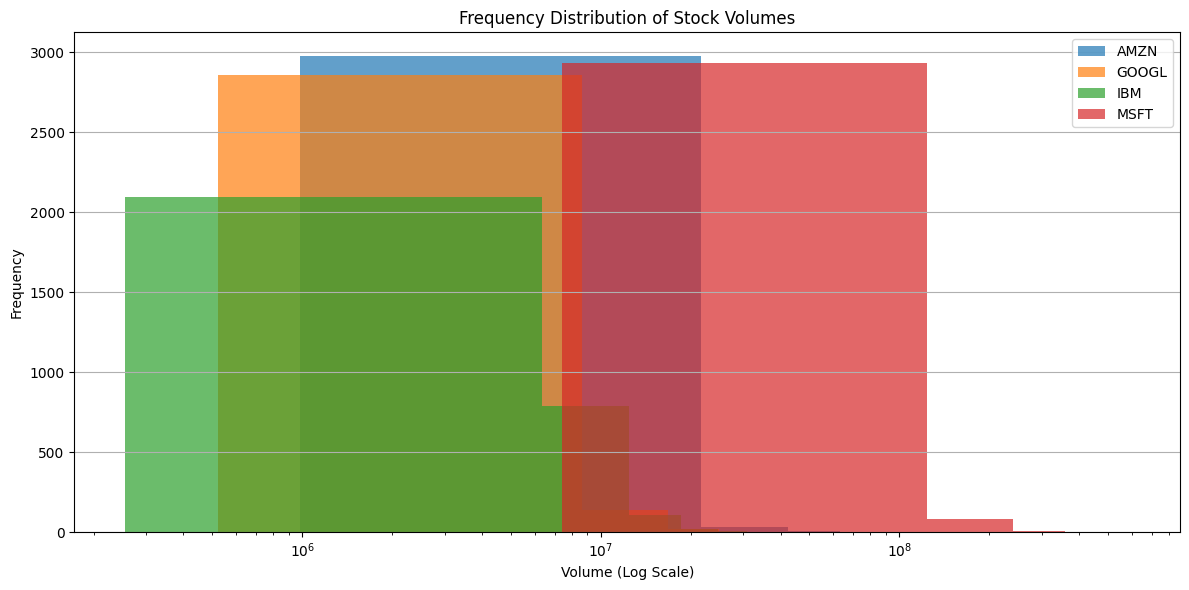

In [467]:
# Frequency distribution of volumes

# Plot volume frequency distributions for each stock
plt.figure(figsize=(12, 6))

# Loop through unique stock names
for stock, group in df_stocks.groupby('Name'):
    plt.hist(group['Volume'], bins=5, alpha=0.7, label=stock)
    
plt.xscale('log')

plt.title('Frequency Distribution of Stock Volumes')
plt.xlabel('Volume (Log Scale)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


**IBM has lower stock volume & Microsoft has higher stock volume than other companies**

In [442]:
df_stocks['Name'].value_counts().plot(kind='bar', figsize=(8, 5), color='blue')

plt.title('Number of Records per Stock')
plt.xlabel('Name')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**All the Companies have same count of records**

In [444]:
# Stock volume variation over time

def plot_stock_volumes(df, target_column):
    """
    Visualizes the target variable over time, and in weekly/monthly/quarterly groups.
    """
    plt.figure(figsize=(14, 4))
    plt.plot(df[target_column])
    plt.title(f"Full Time Series: {target_column}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

    # Weekly average plot
    df_weekly = df[target_column].resample('W').mean()
    plt.figure(figsize=(14, 4))
    plt.plot(df_weekly)
    plt.title(f"Weekly Average: {target_column}")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

    # Monthly average plot
    df_monthly = df[target_column].resample('M').mean()
    plt.figure(figsize=(14, 4))
    plt.plot(df_monthly)
    plt.title(f"Monthly Average: {target_column}")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

    # Quarterly average plot
    df_quarterly = df[target_column].resample('Q').mean()
    plt.figure(figsize=(14, 4))
    plt.plot(df_quarterly)
    plt.title(f"Quarterly Average: {target_column}")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

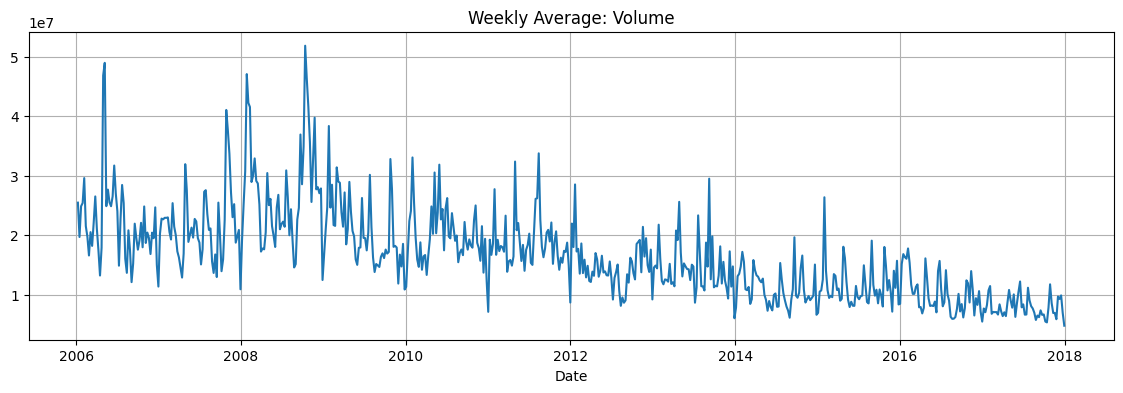

C:\Users\Admin\AppData\Local\Temp\ipykernel_16136\2211983449.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df[target_column].resample('M').mean()


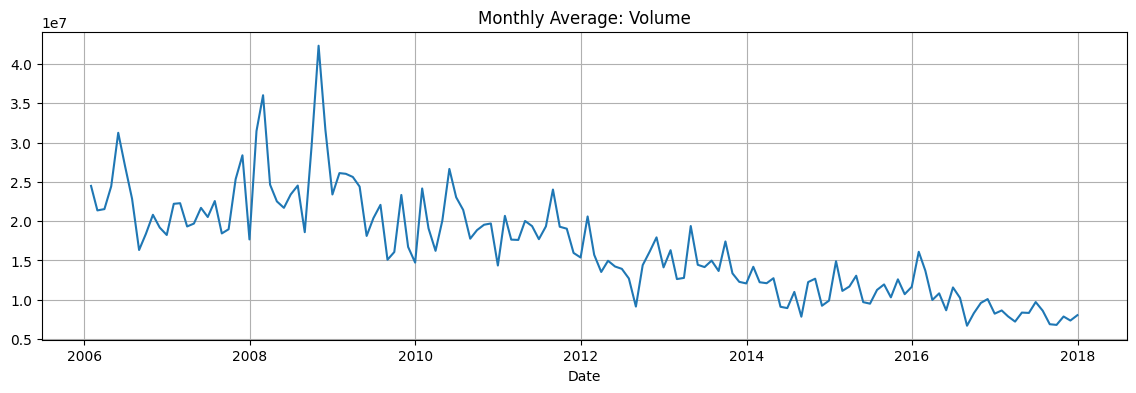

C:\Users\Admin\AppData\Local\Temp\ipykernel_16136\2211983449.py:34: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_quarterly = df[target_column].resample('Q').mean()


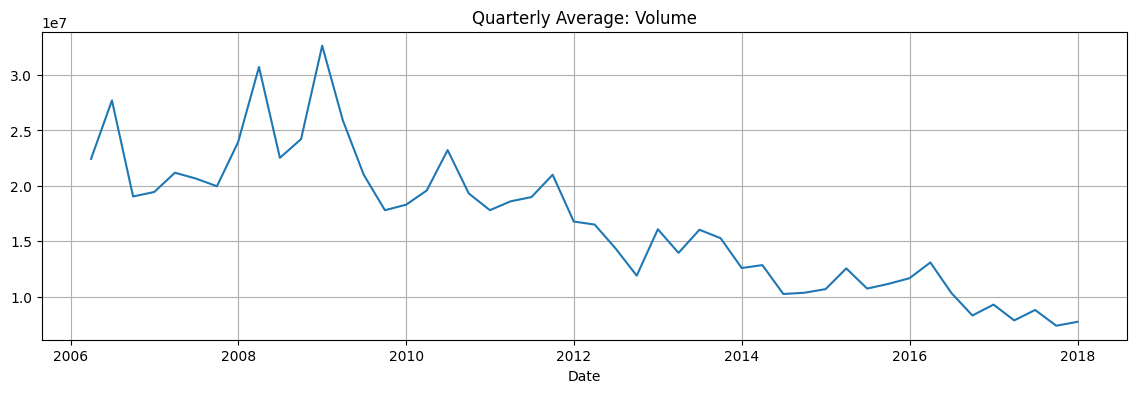

In [446]:
plot_stock_volumes(df_stocks, 'Volume')

**Stock Volumes are High in 2009 & gradually showing decreasing trend towards 2018**

#### Let's analyse All features Open, Close, Low , High & Volume individually for each company for the given period 

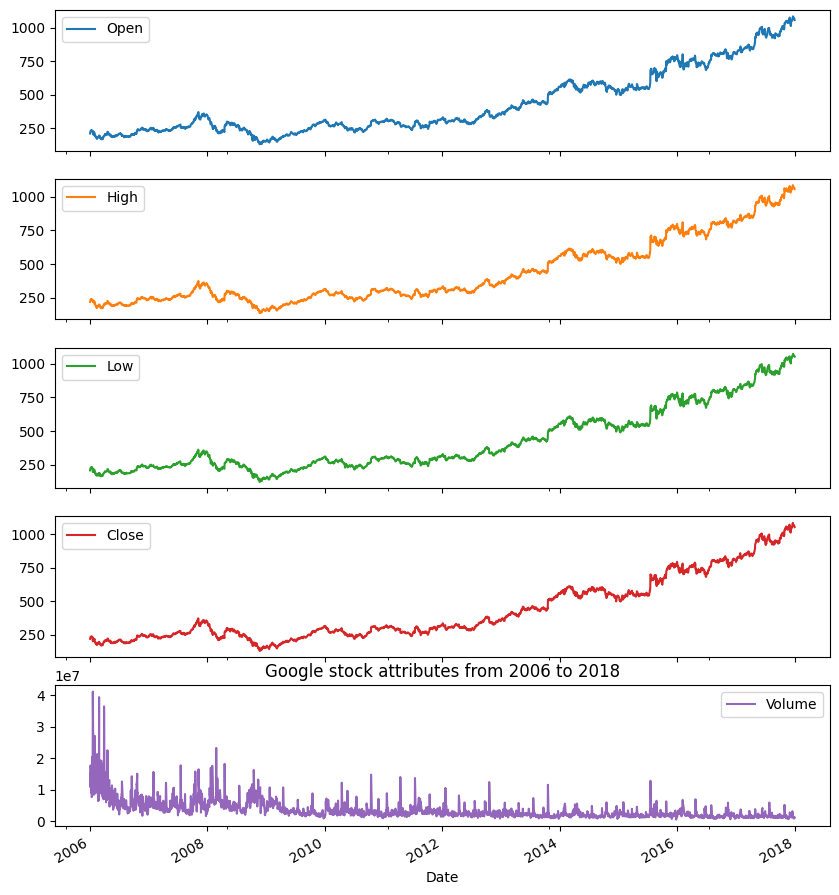

In [449]:

google['2006':'2018'].plot(subplots=True, figsize=(10,12))
plt.title('Google stock attributes from 2006 to 2018')
plt.show()

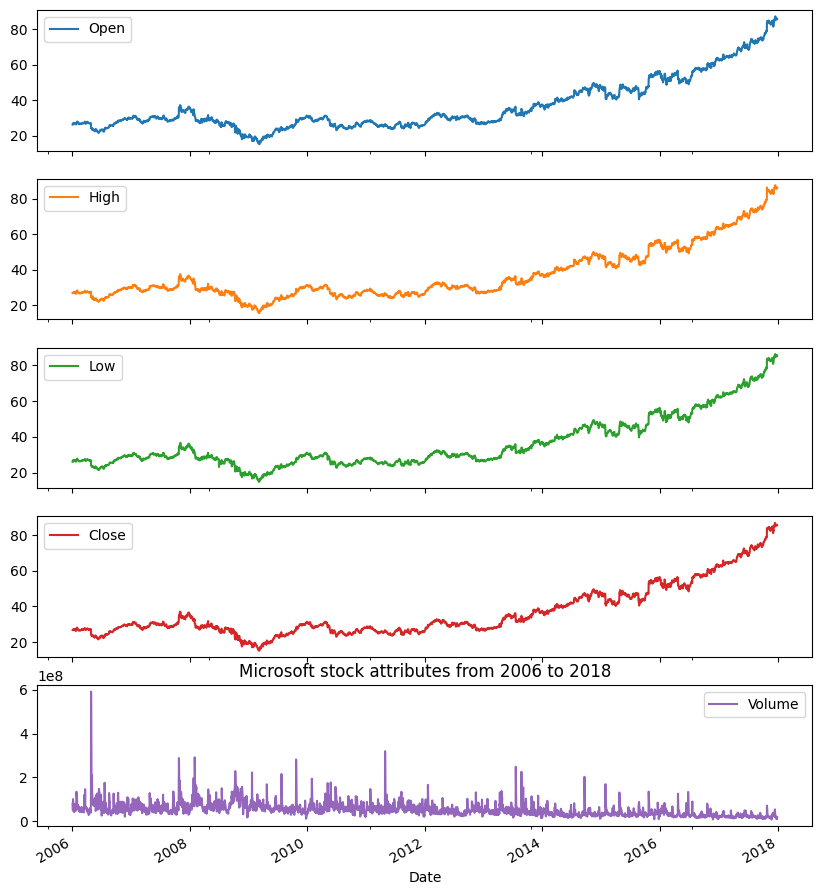

In [451]:

microsoft['2006':'2018'].plot(subplots=True, figsize=(10,12))
plt.title('Microsoft stock attributes from 2006 to 2018')
plt.show()

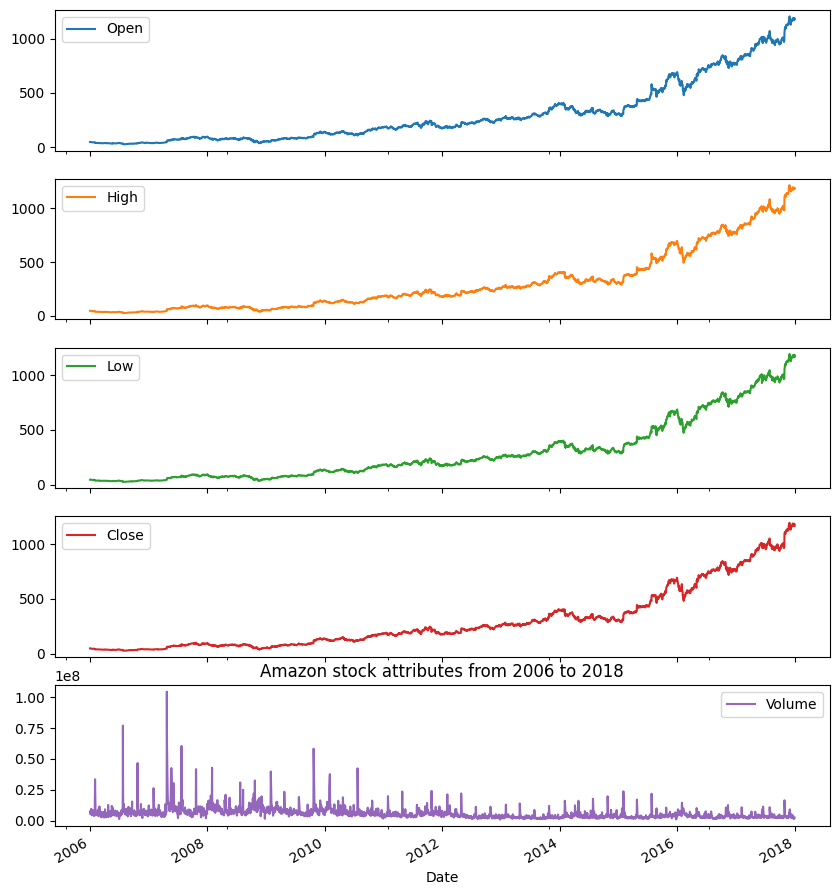

In [453]:
amazon['2006':'2018'].plot(subplots=True, figsize=(10,12))
plt.title('Amazon stock attributes from 2006 to 2018')
plt.show()

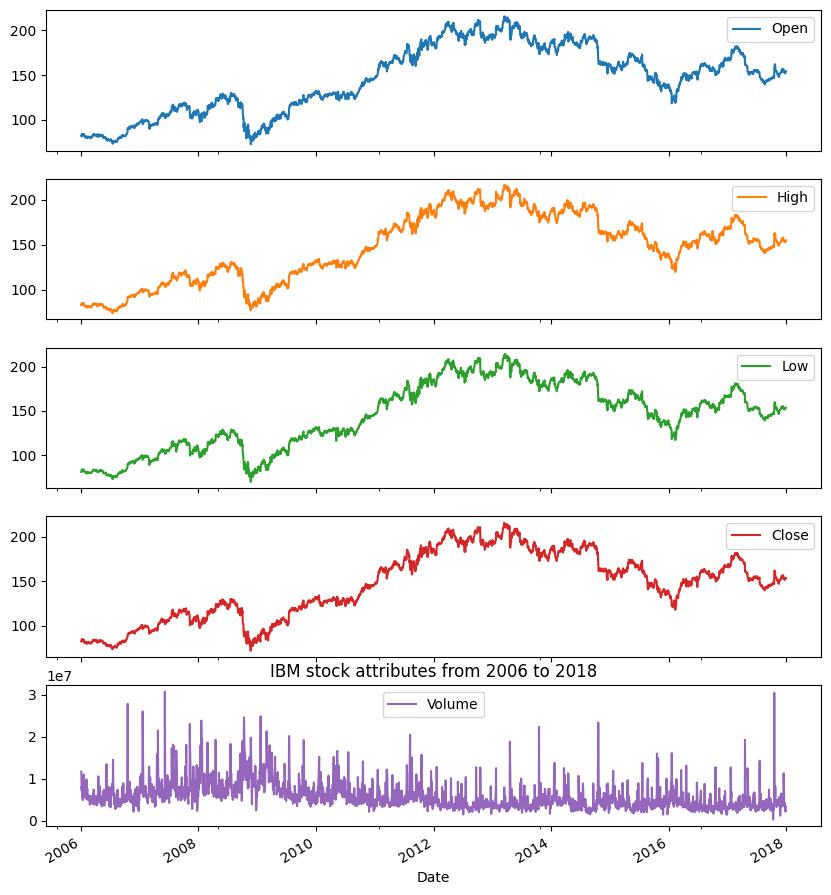

In [455]:
ibm['2006':'2018'].plot(subplots=True, figsize=(10,12))
plt.title('IBM stock attributes from 2006 to 2018')
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

In [460]:
# Analyse correlations
df_stocks_corr = df_stocks[['Open', 'High', 'Low', 'Close']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(df_stocks_corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

#### Let's see each individual company wise correlation between all features

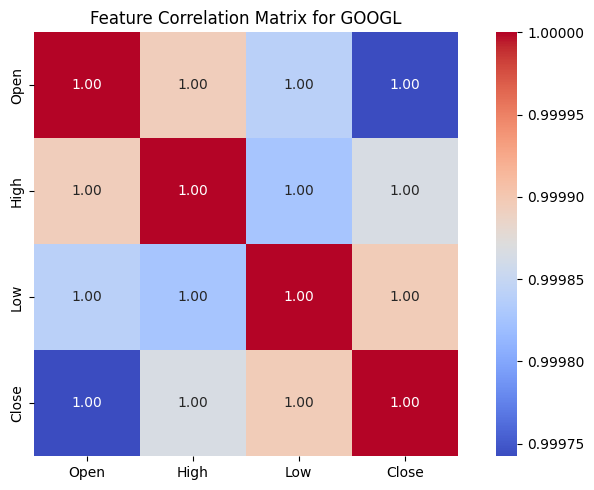

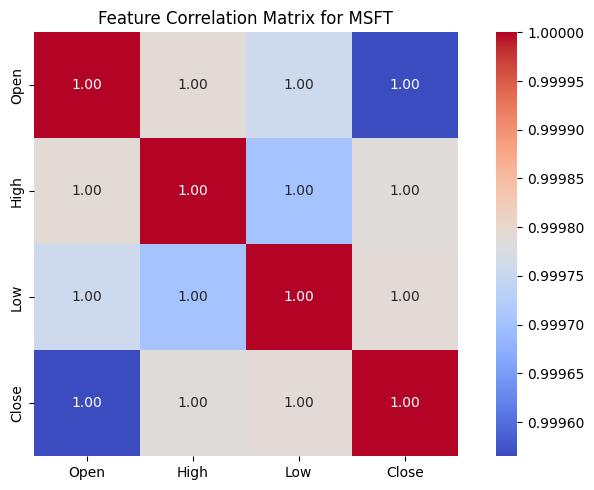

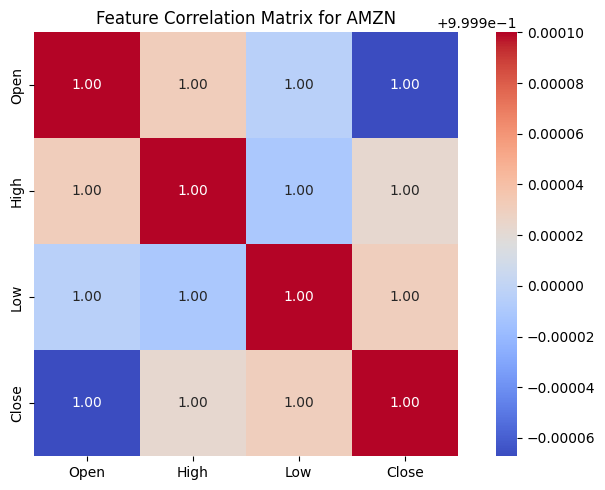

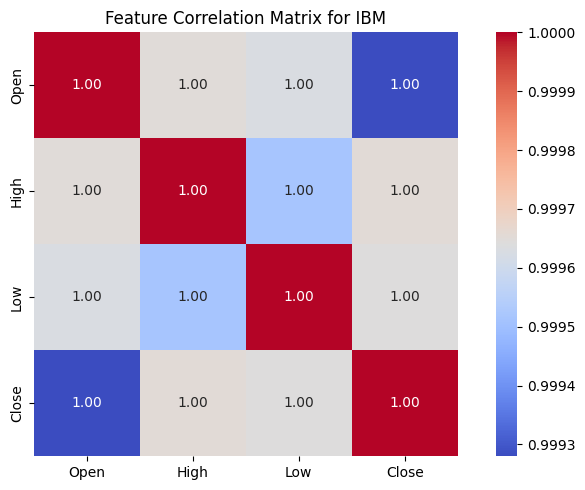

In [463]:
# List of numerical columns to correlate
features = ['Open', 'High', 'Low', 'Close']

# Loop through each company
for stock in df_stocks['Name'].unique():
    stock_df = df_stocks[df_stocks['Name'] == stock]
    corr_matrix = stock_df[features].corr()

    # Plot
    plt.figure(figsize=(8, 5))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
    plt.title(f'Feature Correlation Matrix for {stock}')
    plt.tight_layout()
    plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [87]:
# Define a function that divides the data into windows and generates target variable values for each window

def generate_timeseries_windows(df_stocks, window_size=3, step_size=1, target_col=None):
    """
    Generate windowed X and y datasets from given input time series DataFrame.

    Parameters:
    - df_stocks (pd.DataFrame): Main DataFrame containing all stock data.
    - window_size (int): Number of time steps to include in each input window.
    - step_size (int): Stride length for moving the window.
    - target_col (str): column name to be used as target.

    Returns:
    - X : List of windowed input arrays.
    - y : List of target output values for each input window.
    """
    if target_col is None:
        raise ValueError("Target column name shouldn't be empty")

    X = []
    y = []

    max_index = len(df_stocks) - window_size

    for start_idx in range(0, max_index, step_size):
        end_idx = start_idx + window_size

        stock_window = df_stocks.iloc[start_idx:end_idx].drop(columns=target_col)
        target_idx = end_idx  

        if target_idx >= len(df_stocks):
            break

        input_data = stock_window.values  
        
        target = df_stocks.loc[df_stocks.index[target_idx], target_col]
        
        if isinstance(target, pd.Series):
            target_data = target.values[0]
        else:
            target_data = target
        print(f"target_idx: {target_idx}, target_data: {target_data}")
        X.append(input_data)
        y.append(target_data)

    return X, y


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [89]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_stock_window_data(X_windows):
    """
    Incrementally scales windowed data using MinMaxScaler's partial_fit method.

    Parameters:
    - X_windows : List of input windows

    Returns:
    - scaled_X (list of np.ndarray): List of scaled windows for given input window
    
    """
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit the scaler incrementally
    for stock_window in X_windows:
        scaler.partial_fit(stock_window)

    # Transform the windows
    scaled_X = [scaler.transform(stock_window) for stock_window in X_windows]

    return scaled_X


In [91]:
def scale_targets(y_values):
        y_array = np.vstack(y_values)
        target_scaler = MinMaxScaler(feature_range=(0, 1))
        target_scaler.fit(y_array)
        y_scaled = target_scaler.transform(y_array)
        return y_scaled

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [93]:
# Define a function to create input and output data points from the master DataFrame

def train_test_split(df_stocks, target_cols, window_size=3, step_size=1, split_ratio=0.8):
    """
    Prepares windowed, scaled, and split data for Simple RNN training.

    Parameters:
    - df_stocks (DataFrame): Master dataset.
    - target_cols (list of str): Columns to predict.
    - window_size (int): Number of time steps per input window.
    - step_size (int): Stride between each window.
    - split_ratio (float): Train/test split ratio.

    Returns:
    - X_train, y_train, X_test, y_test: Scaled numpy arrays.
    
    """
    X_raw, y_raw = generate_timeseries_windows(df_stocks, window_size, step_size, target_cols)

    X_scaled = scale_stock_window_data(X_raw)

    X_array = np.array(X_scaled)

    print(X_array.shape)
    
    y_scaled = scale_targets(y_raw)

    split_idx = int(len(X_array) * split_ratio)

    X_train = X_array[:split_idx]
    y_train = y_scaled[:split_idx]
    X_test = X_array[split_idx:]
    y_test = y_scaled[split_idx:]

    return X_train, y_train, X_test, y_test


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [95]:
# Checking for patterns in different sequence lengths

def explore_target_patterns(df, target_column):
    """
    Visualizes the target variable over time, and in weekly/monthly/quarterly groups.
    """
    plt.figure(figsize=(14, 4))
    plt.plot(df[target_column])
    plt.title(f"Full Time Series: {target_column}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

    # Weekly average plot
    df_weekly = df[target_column].resample('W').mean()
    plt.figure(figsize=(14, 4))
    plt.plot(df_weekly)
    plt.title(f"Weekly Average: {target_column}")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

    # Monthly average plot
    df_monthly = df[target_column].resample('M').mean()
    plt.figure(figsize=(14, 4))
    plt.plot(df_monthly)
    plt.title(f"Monthly Average: {target_column}")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

    # Quarterly average plot
    df_quarterly = df[target_column].resample('Q').mean()
    plt.figure(figsize=(14, 4))
    plt.plot(df_quarterly)
    plt.title(f"Quarterly Average: {target_column}")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()



#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [97]:
# Create data instances from the master data frame using decided window size and window stride
target_col = 'Close'
df_stocks = df_stocks[['Open', 'High', 'Low', 'Close', 'Volume']]
X_train, y_train, X_test, y_test = train_test_split(df_stocks, target_col, window_size=3, step_size=1, split_ratio=0.7)

target_idx: 3, target_data: 233.06
target_idx: 4, target_data: 233.68
target_idx: 5, target_data: 235.11
target_idx: 6, target_data: 236.05
target_idx: 7, target_data: 232.05
target_idx: 8, target_data: 233.36
target_idx: 9, target_data: 233.79
target_idx: 10, target_data: 222.68
target_idx: 11, target_data: 218.44
target_idx: 12, target_data: 199.93
target_idx: 13, target_data: 213.96
target_idx: 14, target_data: 221.74
target_idx: 15, target_data: 216.72
target_idx: 16, target_data: 217.35
target_idx: 17, target_data: 216.96
target_idx: 18, target_data: 213.62
target_idx: 19, target_data: 216.55
target_idx: 20, target_data: 201.09
target_idx: 21, target_data: 198.22
target_idx: 22, target_data: 190.97
target_idx: 23, target_data: 192.74
target_idx: 24, target_data: 184.14
target_idx: 25, target_data: 184.72
target_idx: 26, target_data: 179.56
target_idx: 27, target_data: 181.49
target_idx: 28, target_data: 173.02
target_idx: 29, target_data: 171.83
target_idx: 30, target_data: 171.36

In [99]:
df_stocks.head()

Open    High     Low   Close    Volume
Date                                                
2006-01-03  211.47  218.05  209.32  217.83  13137450
2006-01-04  222.17  224.70  220.09  222.84  15292353
2006-01-05  223.22  226.00  220.97  225.85  10815661
2006-01-06  228.66  235.49  226.85  233.06  17759521
2006-01-09  233.44  236.94  230.70  233.68  12795837

In [101]:
# Check the number of data points generated

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8451, 3, 4)
y_train shape: (8451, 1)
X_test shape: (3622, 3, 4)
y_test shape: (3622, 1)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [104]:
# Check if the datasets are compatible inputs to neural networks

def check_rnn_shapes(X_train, y_train, X_test, y_test):
    assert len(X_train.shape) == 3, "X_train should be 3D: (samples, timesteps, features)"
    assert len(X_test.shape) == 3, "X_test should be 3D: (samples, timesteps, features)"
    assert X_train.shape[0] == y_train.shape[0], "Mismatch in X_train and y_train sample count"
    assert X_test.shape[0] == y_test.shape[0], "Mismatch in X_test and y_test sample count"

In [106]:
check_rnn_shapes(X_train, y_train, X_test, y_test)

## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [112]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def build_rnn_model(input_shape, units=50, dropout_rate=0.2, activation='tanh'):
    """
    Build a simple Vanilla RNN model for stock price prediction.
    Args:
        input_shape: shape of input data (num_samples, window_size, num_features)
    Returns:
        Compiled RNN model
    """
    model = Sequential()
    
    # RNN layer
    model.add(SimpleRNN(units=units, activation=activation, input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))  # Regularization to avoid overfitting
    
    # Dense layer to output the prediction 
    model.add(Dense(1))

    return model


In [114]:
input_shape = (X_train.shape[1], X_train.shape[2])
seq_rnn_model = build_rnn_model(input_shape, 50, 0.2, 'tanh')

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [116]:
# Compile the model
seq_rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [118]:
# Fit the RNN model to the training data for 10 epochs, using a batch size of 32
# The training history is stored in the 'history' variable

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = seq_rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0956 - val_loss: 0.0731
Epoch 2/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0487 - val_loss: 0.0590
Epoch 3/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0402 - val_loss: 0.0580
Epoch 4/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0381 - val_loss: 0.0560
Epoch 5/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0378 - val_loss: 0.0559
Epoch 6/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0374 - val_loss: 0.0563
Epoch 7/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0373 - val_loss: 0.0561
Epoch 8/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0371 - val_loss: 0.0540
Epoch 9/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0374 - val_loss: 0.0559
Epoch 10/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0372 - val_loss: 0.0551
Epoch 11/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0371 - val_loss: 0.0553
Epoch 12/100
265/265 ━━━━━━━━━━━━━━━━━━━━

In [120]:
# Define a function to plot the training loss over epochs
def plot_loss(history):
    # Create a figure with a specified size
    plt.figure(figsize=(15, 10))
    
    # Plot the training loss from the 'history' object
    plt.plot(history.history['loss'], label='loss')
    
    # Add a legend and display the plot
    plt.legend(loc='best')
    plt.show()

In [122]:
# Define a function to plot real and predicted values for time series forecasting
def plot_predictions(test, predicted, title):
    # Plot the real values in gray
    plt.plot(test, color="gray", label="Real")
    
    # Plot the predicted values in red
    plt.plot(predicted, color="red", label="Predicted")
    
    # Set the title and labels for the plot
    plt.title(f'{title}')
    plt.xlabel("Date")
    plt.ylabel('Stock Price')
    
    # Add a legend to differentiate real and predicted values
    plt.legend()
    
    # Show the plot
    plt.show()

In [124]:
# Define a function to calculate and print the root mean squared error (RMSE)
def return_rmse(test, predicted):
    # Calculate the RMSE using the mean_squared_error function from scikit-learn
    rmse = np.sqrt(mean_squared_error(test, predicted))
    
    # Print the RMSE
    print("The root mean squared error is {:.2f}.".format(rmse))

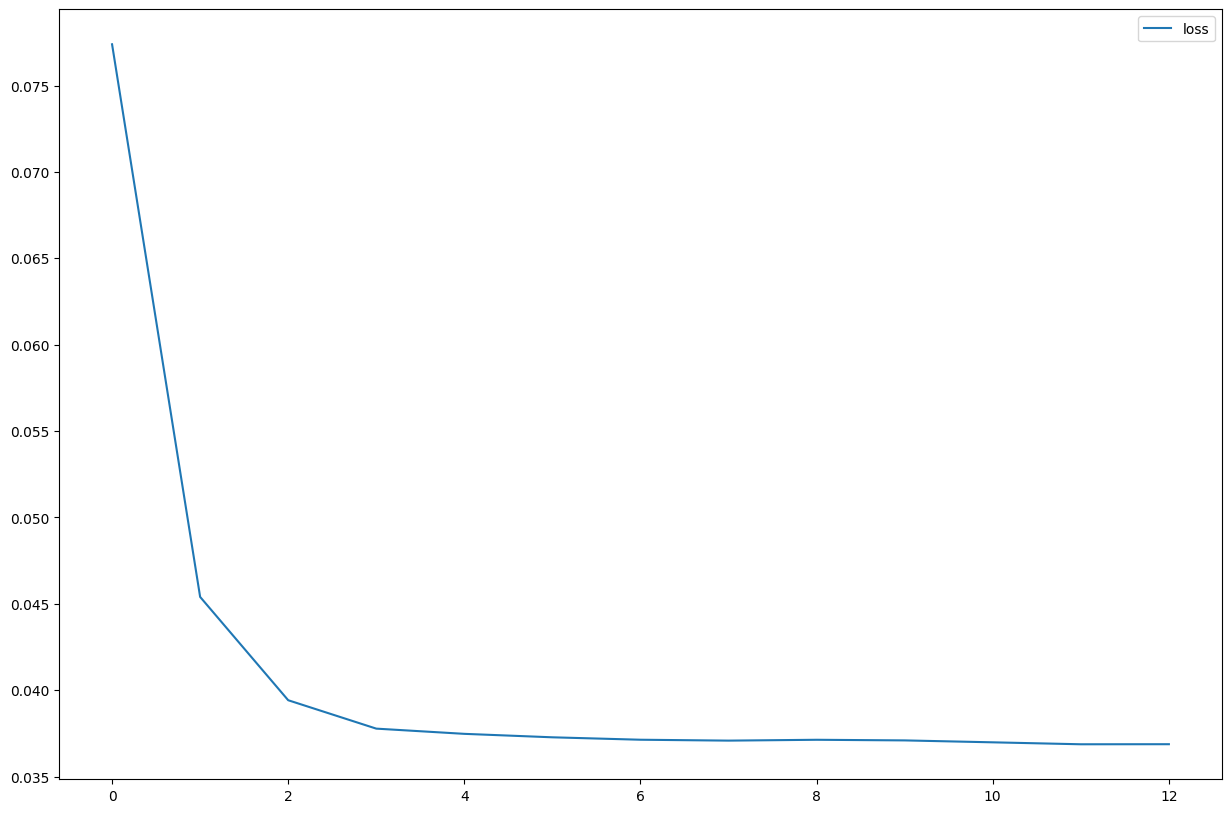

In [126]:
plot_loss(history)

In [128]:
predictions = seq_rnn_model.predict(X_test)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


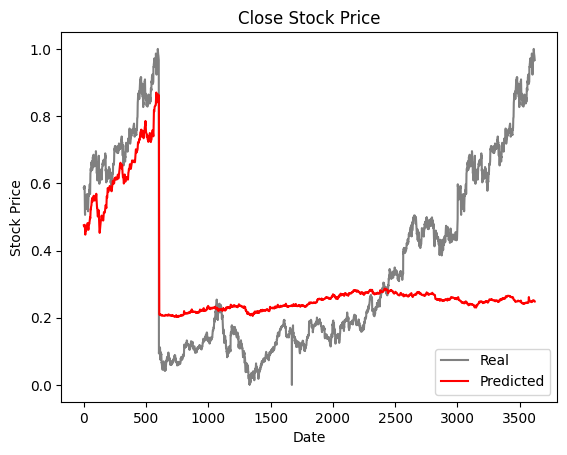

In [130]:
# Plot the real stock prices (test_set) and the predicted Close stock prices
plot_predictions(y_test, predictions, "Close Stock Price")

In [132]:
# Evaluate the model on test data
test_loss = seq_rnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0167 
Test Loss: 0.0540122389793396


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [137]:
# Find an optimal configuration of simple RNN

units_list = [10, 30, 50]  # Number of units
layers_list = [1, 2, 3 ]         # Number of layers
activation_list = ['tanh', 'relu']  # Activation functions
dropout_rates = [0.2, 0.3]  # Dropout rate

# Iterate through combinations
for units in units_list:
    for layers in layers_list:
        for activation in activation_list:
            for dropout in dropout_rates:
                print(f"Training model with {units} units, {layers} layers, {activation} activation, and {dropout} dropout.")
                # Build model for each combination
                model = build_rnn_model(input_shape=(X_train.shape[1], X_train.shape[2]), 
                                        units=units, 
                                        dropout_rate=dropout,
                                        activation=activation)
                model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
                # Fit model
                history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), 
                                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
                
                # Evaluate performance
                test_loss = model.evaluate(X_test, y_test, verbose=0)
                print(f"Test Loss: {test_loss}")


Training model with 10 units, 1 layers, tanh activation, and 0.2 dropout.
Epoch 1/10


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1140 - val_loss: 0.0922
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0633 - val_loss: 0.0733
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0486 - val_loss: 0.0651
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0428 - val_loss: 0.0620
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0399 - val_loss: 0.0612
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0387 - val_loss: 0.0601
Epoch 7/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0379 - val_loss: 0.0599
Epoch 8/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0378 - val_loss: 0.0590
Epoch 9/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0374 - val_loss: 0.0585
Epoch 10/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0374 - val_loss: 0.0586
Test Loss: 0.058461930602788925
Training model with 10 units, 1 layers, tanh activation, and 0.3 dropout.
Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2

In [138]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0331 
Test Loss: 0.08426954597234726


In [139]:
# Find the best configuration based on evaluation metrics
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE : {mse}")
print(f"MAE : {mae}")
print(f"RMSE : {rmse}")
print(f"R2 Score : {r2}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
MSE : 0.08015242406924156
MAE : 0.2152062468543726
RMSE : 0.283112034483244
R2 Score : -0.03621980412448056


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [171]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
optimal_seq_rnn_model = build_rnn_model(input_shape, 10, 0.1, 'tanh')
optimal_seq_rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Plotting the actual vs predicted values

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   


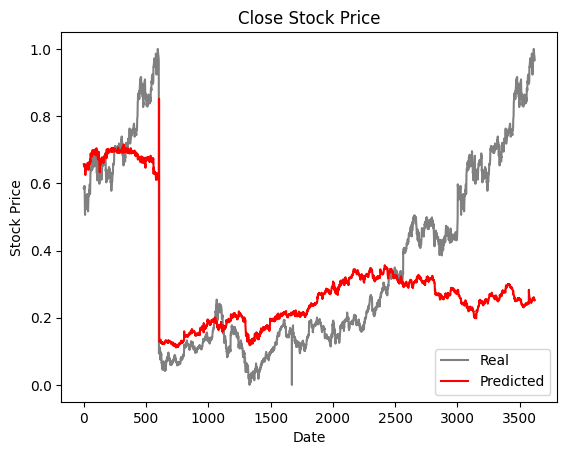

In [174]:
# Predict on the test data and plot
predictions = optimal_seq_rnn_model.predict(X_test)
plot_predictions(y_test, predictions, "Close Stock Price")

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [177]:
# Compute the performance of the model on the testing data set

test_loss = optimal_seq_rnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0874   
Test Loss: 0.12403084337711334


In [179]:
# Find the best configuration based on evaluation metrics
y_pred = optimal_seq_rnn_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE : {mse}")
print(f"MAE : {mae}")
print(f"RMSE : {rmse}")
print(f"R2 Score : {r2}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
MSE : 0.051088909977072924
MAE : 0.1574369003877138
RMSE : 0.22602856009157984
R2 Score : 0.3395166658510186


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [ ]:
input_shape, units=10, dropout_rate=0.1, activation='tanh', learning_rate=0.0001

In [181]:
# # Define a function to create a model and specify default values for hyperparameters
def build_lstm_model(input_shape, units=125, dropout_rate=0.1, activation='tanh', learning_rate=0.0001):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=units, activation=activation, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))  # Dropout layer for regularization

    # Second LSTM layer
    model.add(LSTM(units=units, activation=activation, return_sequences=False))
    model.add(Dropout(dropout_rate))  # Dropout layer for regularization
    
    # Dense layer for the output
    model.add(Dense(1))  # Output layer (single prediction value)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model

In [183]:
# Compile the model using the RMSprop optimizer and (MSE) as the loss function
lstm_model = build_lstm_model(input_shape)

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [185]:
# Fit the model using the training data
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

Epoch 1/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0714 - val_loss: 0.0573
Epoch 2/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0357 - val_loss: 0.0580
Epoch 3/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0352 - val_loss: 0.0584
Epoch 4/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0344 - val_loss: 0.0594
Epoch 5/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0337 - val_loss: 0.0606
Epoch 6/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0332 - val_loss: 0.0617


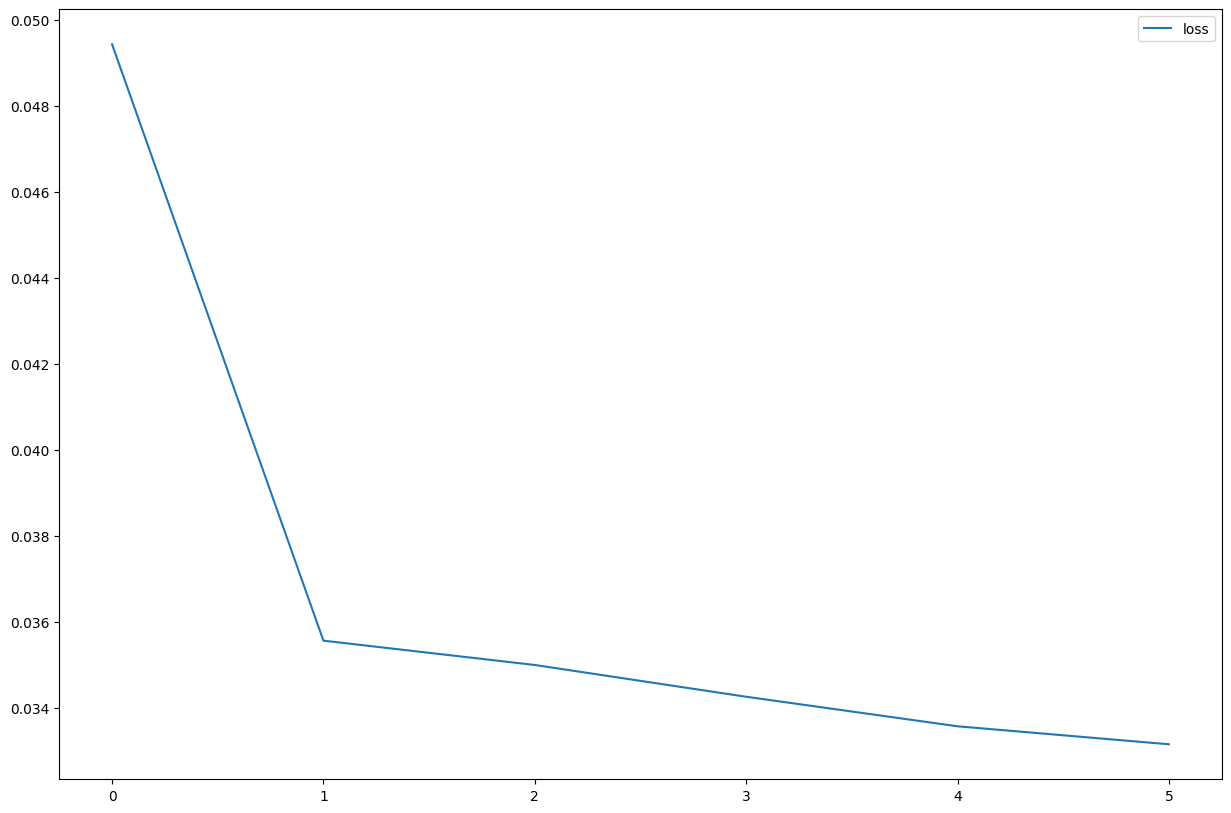

In [186]:
plot_loss(history)

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   


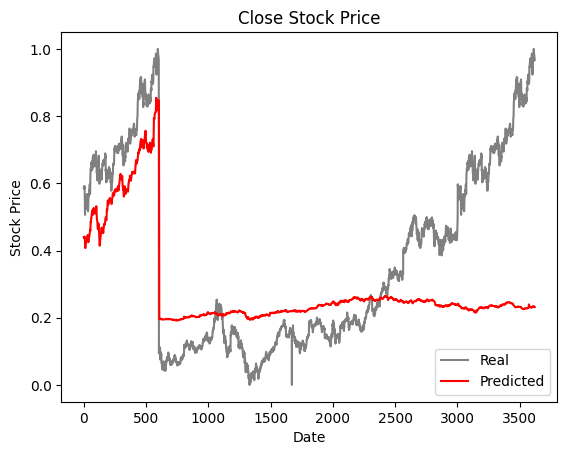

In [187]:
# Predict on the test data and plot
predictions = lstm_model.predict(X_test)
plot_predictions(y_test, predictions, "Close Stock Price")

In [188]:
# Compute the performance of the model on the testing data set

test_loss = lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192 
Test Loss: 0.057343434542417526


In [193]:
# Find the best configuration based on evaluation metrics
y_pred = lstm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE : {mse}")
print(f"MAE : {mae}")
print(f"RMSE : {rmse}")
print(f"R2 Score : {r2}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MSE : 0.05734344045610741
MAE : 0.1767919054144481
RMSE : 0.2394649044350913
R2 Score : 0.25865737278363876


In [205]:
# Define GRU model
def build_gru_model(input_shape, units=100, dropout_rate=0.3, activation='tanh', learning_rate=0.001):
    model = Sequential()
    
    # First GRU layer
    model.add(GRU(units=units, activation=activation, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    
    # Second GRU layer
    model.add(GRU(units=units, activation=activation, return_sequences=False))
    model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))  # Predict one value (e.g., stock price)
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    return model

In [207]:
# Compile the model using the RMSprop optimizer and (MSE) as the loss function
gru_model = build_gru_model(input_shape)

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [209]:
# Fit the model using the training data
history = gru_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

Epoch 1/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0426 - val_loss: 0.0586
Epoch 2/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0349 - val_loss: 0.0603
Epoch 3/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0328 - val_loss: 0.0624
Epoch 4/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0322 - val_loss: 0.0641
Epoch 5/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0318 - val_loss: 0.0652
Epoch 6/100
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0316 - val_loss: 0.0657


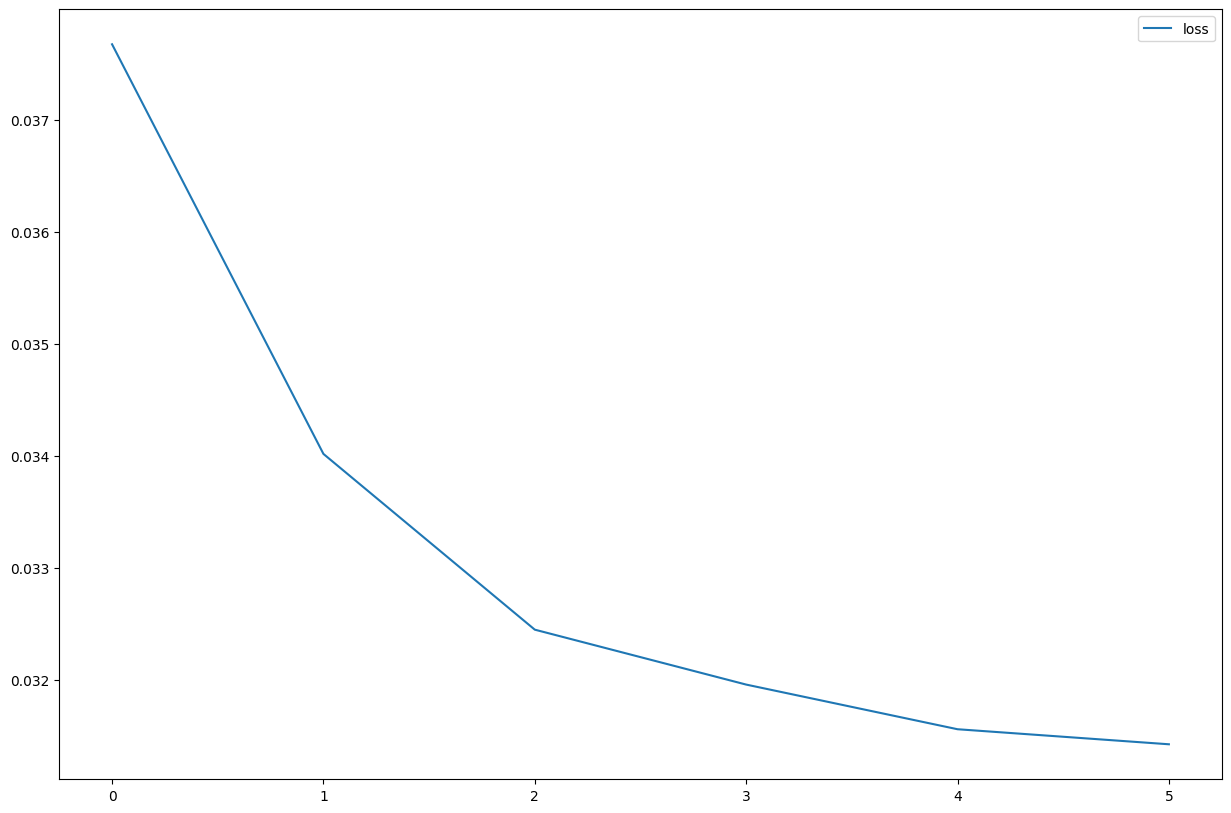

In [210]:
plot_loss(history)

In [211]:
# Compute the performance of the model on the testing data set

test_loss = gru_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 
Test Loss: 0.058636996895074844


In [212]:
# Find the best configuration based on evaluation metrics
y_pred = gru_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE : {mse}")
print(f"MAE : {mae}")
print(f"RMSE : {rmse}")
print(f"R2 Score : {r2}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
MSE : 0.05863700634599258
MAE : 0.16642536112869005
RMSE : 0.24215079257766756
R2 Score : 0.24193400342077365


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [195]:
# Find an optimal configuration


units_list = [10, 30, 50]  # Number of units
layers_list = [1, 2, 3 ]         # Number of layers
activation_list = ['tanh', 'relu']  # Activation functions
dropout_rates = [0.2, 0.3]  # Dropout rate

# Iterate through combinations
for units in units_list:
    for layers in layers_list:
        for activation in activation_list:
            for dropout in dropout_rates:
                print(f"Training model with {units} units, {layers} layers, {activation} activation, and {dropout} dropout.")
                # Build model for each combination
                model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), 
                                        units=units, 
                                        dropout_rate=dropout,
                                        activation=activation)
                model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
                # Fit model
                history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), 
                                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
                
                # Evaluate performance
                test_loss = model.evaluate(X_test, y_test, verbose=0)
                print(f"Test Loss: {test_loss}")

Training model with 10 units, 1 layers, tanh activation, and 0.2 dropout.
Epoch 1/10


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0664 - val_loss: 0.0587
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0365 - val_loss: 0.0576
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0351 - val_loss: 0.0608
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0346 - val_loss: 0.0601
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0345 - val_loss: 0.0610
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0343 - val_loss: 0.0610
Epoch 7/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0340 - val_loss: 0.0606
Test Loss: 0.05764768645167351
Training model with 10 units, 1 layers, tanh activation, and 0.3 dropout.
Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0742 - val_loss: 0.0590
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0385 - val_loss: 0.0597
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0361 - val_loss: 0.0587
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [307]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
def build_tuned_gru_model(input_shape, units=50, dropout_rate=0.2,  activation='tanh', learning_rate=0.001, bidirectional=True):
    model = Sequential()
    
    if bidirectional:
        model.add(Bidirectional(GRU(units=units, activation=activation, return_sequences=True), input_shape=input_shape))
    else:
        model.add(GRU(units=units, activation=activation, return_sequences=True, input_shape=input_shape))
        
    model.add(Dropout(dropout_rate))

    if bidirectional:
        model.add(Bidirectional(GRU(units=units, activation=activation, return_sequences=False)))
    else:
        model.add(GRU(units=units, activation=activation, return_sequences=False))

    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Regression output

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


In [309]:
# Build the tuned model
input_shape = (X_train.shape[1], X_train.shape[2])
tuned_gru_model = build_tuned_gru_model(input_shape)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train
history = tuned_gru_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0394 - val_loss: 0.0579
Epoch 2/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0329 - val_loss: 0.0592
Epoch 3/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0320 - val_loss: 0.0605
Epoch 4/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0317 - val_loss: 0.0635
Epoch 5/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0312 - val_loss: 0.0657
Epoch 6/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0299 - val_loss: 0.0916
Epoch 7/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0227 - val_loss: 0.0959
Epoch 8/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0163 - val_loss: 0.0939
Epoch 9/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0134 - val_loss: 0.0939
Epoch 10/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0123 - val_loss: 0.0941
Epoch 11/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0119 - val_loss: 0.0913


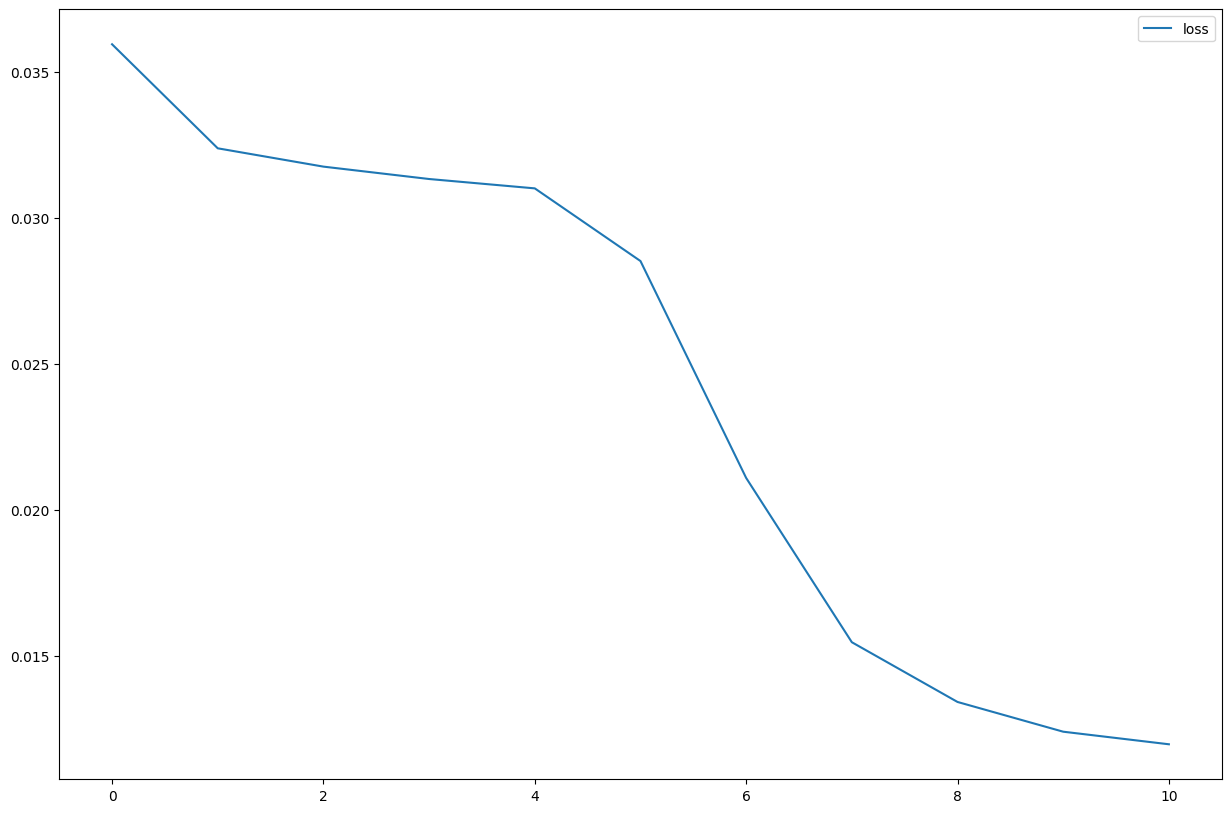

In [310]:
plot_loss(history)

In [311]:
# Compute the performance of the model on the testing data set
test_loss = tuned_gru_model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss}")

Test Loss: 0.057903166860342026


Plotting the actual vs predicted values

In [313]:
# Predict on the test data
y_pred = tuned_gru_model.predict(X_test)

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   


In [314]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE : {mse}")
print(f"MAE : {mae}")
print(f"RMSE : {rmse}")
print(f"R2 Score : {r2}")

MSE : 0.057903165870510795
MAE : 0.17834035434825263
RMSE : 0.2406307666748182
R2 Score : 0.2514211779210165


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

#### Observations from Raw Data
1. Total of 4 Stocks Amazon, Google, Microsoft & IBM
2. All the Stock files have equal number of records 3019 except IBM which has 3020 records
3. All the Open, Close, Low & High Stock Prices are with in the ranges of 15 to 1200
4. IBM has lower stock volume & Microsoft has higher stock volume than other companies
5. Stock Volumes are High in 2008 & gradually showing decreasing trend towards 2018

#### Models & Evaluation
1. Close Stock Price feature used for Prediction
2. As a first Step Simple or Vanilla Sequential RNN has been used with 1 dense layer and default parameters
3. Optimized the Sequential with Hyper Tunning using various combinations of activation functions, Units, dropout rates & learning rate
4. Further optimized using Advanced RNN model Long Short Term Memory (LSTM) model to increase the Regression performance
5. Further optimized using Advanced RNN model Gated Recurrent Unit (GRU) model to increase the Regression performance
6. mean_squared_error considered as evaluation metric for Regression

#### RNN Evaluation Metrics
1. Optimized Sequential RNN given test loss of 0.054 & RMSE 0.28
2. Optimized LSTM Model given test loss of test loss of 0.057 & RMSE 0.23
3. Optimized GRU Model given test loss of 0.0579 & RMSE 0.24
4. Plotted the Test Loss & Prediction metrics after each evaluation
5. One common thing noticed irrespective of changing various Hyper Parameters & did grid search results are almost close 